In [32]:
# %% Paths (robust to running notebook from / or /notebooks)
import os, pickle, sklearn, nltk
print("scikit-learn version:", sklearn.__version__)

CWD = os.getcwd()
PROJECT_ROOT = os.path.dirname(CWD) if os.path.basename(CWD).lower() == "notebooks" else CWD

DATA_DIR   = os.path.join(PROJECT_ROOT, "data")
MODELS_DIR = os.path.join(PROJECT_ROOT, "models")
os.makedirs(MODELS_DIR, exist_ok=True)

PRIMARY_DATA_PATH  = os.path.join(DATA_DIR, "cleaned_customer_data.csv")
FALLBACK_DATA_PATH = os.path.join(PROJECT_ROOT, "data", "cleaned_customer_data.csv")  # same as above, for safety

VEC_PATH   = os.path.join(MODELS_DIR, "sentiment_vectorizer.pkl")
MODEL_PATH = os.path.join(MODELS_DIR, "sentiment_model.pkl")

print("PROJECT_ROOT:", PROJECT_ROOT)
print("MODELS_DIR  :", MODELS_DIR)
print("Saving to   :", VEC_PATH, "and", MODEL_PATH)


scikit-learn version: 1.4.2
PROJECT_ROOT: /Users/shubhau/Documents/capstone
MODELS_DIR  : /Users/shubhau/Documents/capstone/models
Saving to   : /Users/shubhau/Documents/capstone/models/sentiment_vectorizer.pkl and /Users/shubhau/Documents/capstone/models/sentiment_model.pkl


In [33]:
# %% Train sentiment model (atomic cell)
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from nltk.sentiment import SentimentIntensityAnalyzer
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import nltk
# %% Topic Modeling (LDA) on RAW feedback_text — with THEME mapping everywhere
from sklearn.decomposition import LatentDirichletAllocation


# Ensure VADER is available
try:
    nltk.download("vader_lexicon", quiet=True)
except Exception:
    pass
sia = SentimentIntensityAnalyzer()

# --- Load data ---
data_path = PRIMARY_DATA_PATH if os.path.exists(PRIMARY_DATA_PATH) else FALLBACK_DATA_PATH
df = pd.read_csv(data_path)
df = df.dropna(subset=["feedback_text"]).copy()
df["feedback_text"] = df["feedback_text"].astype(str)

# --- Create weak labels with VADER ---
def label_from_compound(c):
    if c >= 0.05:
        return "Positive"
    elif c <= -0.05:
        return "Negative"
    else:
        return "Neutral"

df["vader_compound"]   = df["feedback_text"].apply(lambda t: sia.polarity_scores(t)["compound"])
df["sentiment_label"]  = df["vader_compound"].apply(label_from_compound)

# --- Split ---
X_train_text, X_test_text, y_train, y_test = train_test_split(
    df["feedback_text"].values,
    df["sentiment_label"].values,
    test_size=0.2,
    random_state=42,
    stratify=df["sentiment_label"].values if df["sentiment_label"].nunique() > 1 else None,
)

# --- Vectorize (RAW text) ---
vectorizer = TfidfVectorizer(
    lowercase=True,
    stop_words="english",
    ngram_range=(1, 2),
    min_df=1,
    max_df=0.95
)
X_train = vectorizer.fit_transform(X_train_text)  # <-- FIT HAPPENS HERE
X_test  = vectorizer.transform(X_test_text)

# --- Classifier ---
clf = LogisticRegression(max_iter=1000, class_weight="balanced")
clf.fit(X_train, y_train)

# --- Eval ---
y_pred = clf.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}\n")
print("Classification report:")
print(classification_report(y_test, y_pred))
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 1.0000

Classification report:
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00       372
     Neutral       1.00      1.00      1.00       128
    Positive       1.00      1.00      1.00       745

    accuracy                           1.00      1245
   macro avg       1.00      1.00      1.00      1245
weighted avg       1.00      1.00      1.00      1245

Confusion matrix:
[[372   0   0]
 [  0 128   0]
 [  0   0 745]]


In [34]:
# %% Save artifacts + integrity checks
# Vectorizer must be fitted (has idf_)
assert hasattr(vectorizer, "idf_"), "Vectorizer is NOT fitted. Run the training cell first."

# Model feature count must match vectorizer feature space
n_vec_feats   = len(getattr(vectorizer, "vocabulary_", {}))
n_model_feats = clf.coef_.shape[1]
assert n_vec_feats == n_model_feats, f"Feature mismatch: vec={n_vec_feats}, model={n_model_feats}"

with open(VEC_PATH, "wb") as f:
    pickle.dump(vectorizer, f)
with open(MODEL_PATH, "wb") as f:
    pickle.dump(clf, f)

print("Saved vectorizer ->", VEC_PATH)
print("Saved model      ->", MODEL_PATH)


Saved vectorizer -> /Users/shubhau/Documents/capstone/models/sentiment_vectorizer.pkl
Saved model      -> /Users/shubhau/Documents/capstone/models/sentiment_model.pkl


In [35]:
# %% Reload + smoke test
with open(VEC_PATH, "rb") as f:
    _vec = pickle.load(f)
with open(MODEL_PATH, "rb") as f:
    _clf = pickle.load(f)

# Must still be fitted and aligned
assert hasattr(_vec, "idf_"), "Reloaded vectorizer is NOT fitted."
assert _clf.coef_.shape[1] == len(_vec.vocabulary_), "Reloaded artifacts are mismatched."

def predict_sentiment_label(text: str) -> str:
    if text is None or not str(text).strip():
        return "Neutral"
    X = _vec.transform([text])
    raw = _clf.predict(X)[0]
    mapping = {"positive": "Positive", "negative": "Negative", "neutral": "Neutral"}
    return mapping.get(str(raw).strip().lower(), str(raw))

# API-like test (what your /predict returns)
tests = ["good", "bad", "okay", "Terrible experience", "Loved it!", ""]
for t in tests:
    print(f"{t!r} ->", predict_sentiment_label(t))


'good' -> Positive
'bad' -> Positive
'okay' -> Positive
'Terrible experience' -> Negative
'Loved it!' -> Positive
'' -> Neutral


,char_len,word_len
count,6225.00,6225.00
mean,32.38,4.87
std,5.51,1.14
min,25.00,3.00
25%,27.00,4.00
50%,32.00,5.00
75%,39.00,6.00
max,41.00,7.00


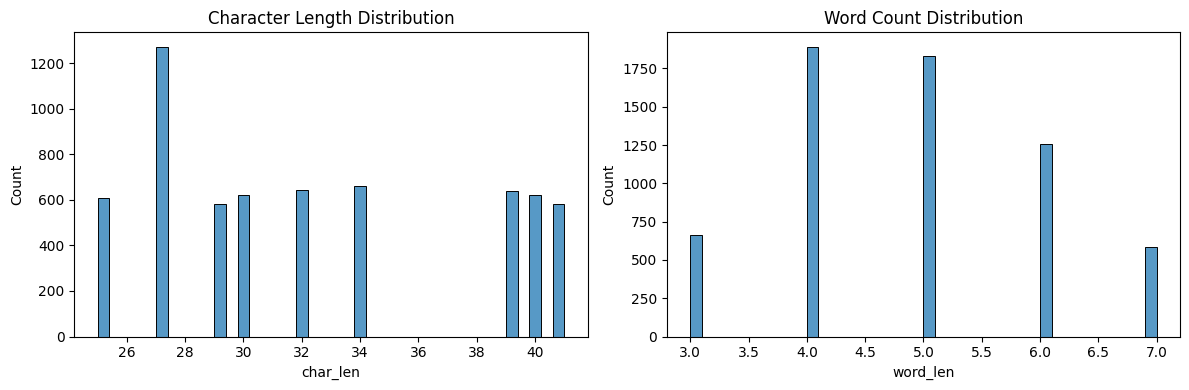

Top Unigrams


,ngram,count
0,product,1263
1,happy,1166
2,excellent,661
3,service,661
4,customer,661
5,met,659
6,special,659
7,expectations,659
8,better,641
9,quality,641


Top Bigrams


,ngram,count
0,customer service,661
1,excellent customer,661
2,met expectations,659
3,expectations special,659
4,quality better,641
5,product quality,641
6,features offered,638
7,expensive features,638
8,product satisfied,622
9,great product,622


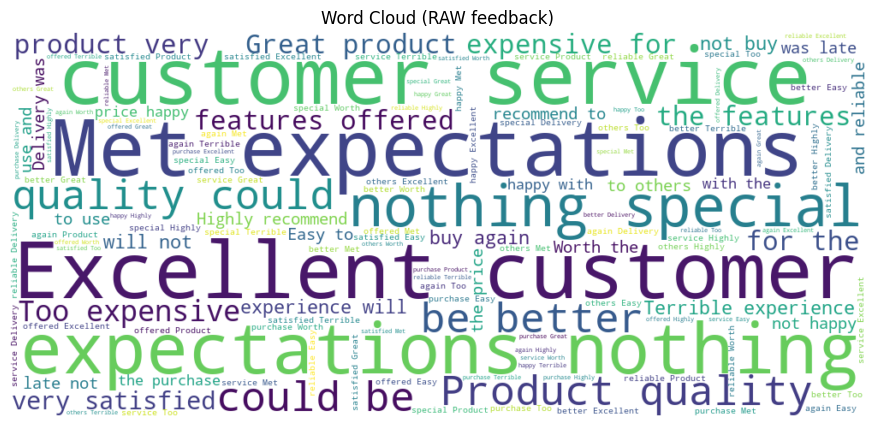

VADER label counts:


vader_label
Positive    3726
Negative    1861
Neutral      638
Name: count, dtype: int64

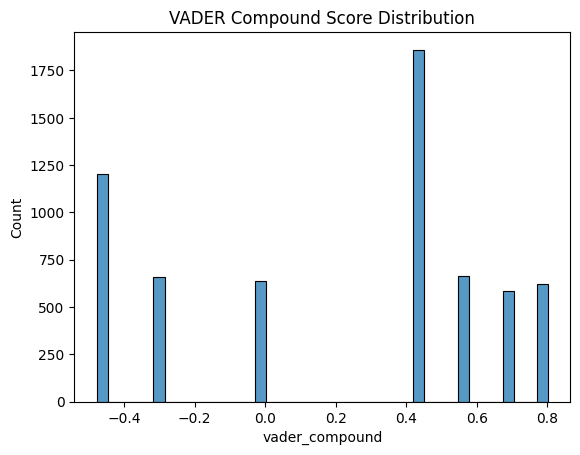

In [36]:


# Ensure df exists and has feedback_text
assert "df" in globals(), "Expected a DataFrame named df."
assert "feedback_text" in df.columns, "df must have 'feedback_text' column."
df = df.dropna(subset=["feedback_text"]).copy()
df["feedback_text"] = df["feedback_text"].astype(str)

# --- basic lengths
df["char_len"] = df["feedback_text"].str.len()
df["word_len"] = df["feedback_text"].str.split().apply(len)
display(df[["char_len", "word_len"]].describe().round(2))

fig, ax = plt.subplots(1, 2, figsize=(12,4))
sns.histplot(df["char_len"], bins=40, ax=ax[0])
ax[0].set_title("Character Length Distribution")
sns.histplot(df["word_len"], bins=40, ax=ax[1])
ax[1].set_title("Word Count Distribution")
plt.tight_layout()
plt.show()

# --- top unigrams / bigrams (RAW text)
def top_ngrams(corpus, ngram_range=(1,1), top_k=25, stop_words="english", max_df=0.95, min_df=2):
    cv = CountVectorizer(ngram_range=ngram_range, stop_words=stop_words, max_df=max_df, min_df=min_df)
    X = cv.fit_transform(corpus)
    freqs = np.asarray(X.sum(axis=0)).ravel()
    vocab = np.array(cv.get_feature_names_out())
    order = freqs.argsort()[::-1][:top_k]
    return pd.DataFrame({"ngram": vocab[order], "count": freqs[order]})

top_uni = top_ngrams(df["feedback_text"], (1,1), 25)
top_bi  = top_ngrams(df["feedback_text"], (2,2), 25)

print("Top Unigrams")
display(top_uni)
print("Top Bigrams")
display(top_bi)

# --- optional word cloud
try:
    from wordcloud import WordCloud
    wc = WordCloud(width=1000, height=450, background_color="white", stopwords=set())
    blob = " ".join(df["feedback_text"])
    plt.figure(figsize=(12,5))
    plt.imshow(wc.generate(blob), interpolation="bilinear")
    plt.axis("off")
    plt.title("Word Cloud (RAW feedback)")
    plt.show()
except Exception as e:
    print("wordcloud not installed; skipping (pip install wordcloud to enable).")

# --- VADER distribution (quick sense-check)
try:
    nltk.download("vader_lexicon", quiet=True)
except Exception:
    pass
sia = SentimentIntensityAnalyzer()
df["vader_compound"] = df["feedback_text"].apply(lambda t: sia.polarity_scores(t)["compound"])
df["vader_label"] = pd.cut(
    df["vader_compound"], bins=[-1.0, -0.05, 0.05, 1.0], labels=["Negative","Neutral","Positive"], include_lowest=True
)

print("VADER label counts:")
display(df["vader_label"].value_counts())

sns.histplot(df["vader_compound"], bins=40)
plt.title("VADER Compound Score Distribution")
plt.show()


In [37]:
# %% Top TF-IDF terms per sentiment (using VADER pseudo-labels)

# ensure labels exist (created above)
assert "vader_label" in df.columns, "Run the VADER cell first."

tfidf_view = TfidfVectorizer(stop_words="english", ngram_range=(1,2), min_df=2, max_df=0.95)
X_all = tfidf_view.fit_transform(df["feedback_text"])
feature_names = np.array(tfidf_view.get_feature_names_out())

def top_terms_for_class(label, top_k=20):
    idx = (df["vader_label"] == label).values
    if idx.sum() == 0:
        return pd.DataFrame({"term": [], "score": []})
    class_mean = X_all[idx].mean(axis=0).A1  # average tf-idf in this class
    order = np.argsort(class_mean)[::-1][:top_k]
    return pd.DataFrame({"term": feature_names[order], "score": class_mean[order]})

for c in ["Positive","Neutral","Negative"]:
    print(f"\nTop terms for {c}")
    display(top_terms_for_class(c, 20))



Top terms for Positive


,term,score
0,product,0.124447
1,highly recommend,0.094521
2,recommend,0.094521
3,highly,0.094521
4,product quality,0.079962
5,quality,0.079962
6,quality better,0.079962
7,better,0.079962
8,service,0.079337
9,customer,0.079337



Top terms for Neutral


,term,score
0,offered,0.447214
1,features offered,0.447214
2,features,0.447214
3,expensive features,0.447214
4,expensive,0.447214
5,worth price,0.000000
6,highly,0.000000
7,happy,0.000000
8,great product,0.000000
9,great,0.000000



Top terms for Negative


,term,score
0,expectations,0.158363
1,expectations special,0.158363
2,special,0.158363
3,met,0.158363
4,met expectations,0.158363
5,buy,0.148751
6,terrible experience,0.148751
7,terrible,0.148751
8,experience buy,0.148751
9,experience,0.148751


In [38]:

# CountVectorizer for topics (avoid clashing name 'vectorizer')
topic_cv = CountVectorizer(
    stop_words="english",
    lowercase=True,
    min_df=5,        # adjust if dataset is small/large
    max_df=0.95,
    ngram_range=(1,1),
    max_features=20000
)
X_counts = topic_cv.fit_transform(df["feedback_text"])
vocab = np.array(topic_cv.get_feature_names_out())

NUM_TOPICS = 5     # tune as needed
TOP_N_WORDS = 12

lda_model = LatentDirichletAllocation(
    n_components=NUM_TOPICS,
    random_state=42,
    learning_method="batch",
    max_iter=20,
    doc_topic_prior=None,    # use defaults
    topic_word_prior=None
)
lda_model.fit(X_counts)

# ---------------------------
# Map topic IDs -> human-readable themes
# EDIT these names if the top words change after re-running LDA
THEME_MAP = {
    0: "Service & Reliability",
    1: "Recommendations / Promoters",
    2: "Delivery & Fulfillment Issues",
    3: "Features vs Price / Value",
    4: "Product Quality & Satisfaction",
}
def get_theme(k: int) -> str:
    return THEME_MAP.get(k, f"Topic {k}")

# ---------------------------
# topic -> top words table (include topic + theme)
topics_rows = []
for k, comp in enumerate(lda_model.components_):
    order = np.argsort(comp)[::-1][:TOP_N_WORDS]
    topics_rows.append({
        "topic": k,
        "theme": get_theme(k),
        "top_words": ", ".join(vocab[order]),
    })
topics_df = pd.DataFrame(topics_rows, columns=["topic", "theme", "top_words"])
print("LDA topics (top words):")
display(topics_df)

# ---------------------------
# document-topic distribution
doc_topic = lda_model.transform(X_counts)  # shape: (n_docs, K)
dominant_topic = doc_topic.argmax(axis=1)
dominant_score = doc_topic.max(axis=1)

df_topics = pd.DataFrame(doc_topic, columns=[f"topic_{i}" for i in range(NUM_TOPICS)])
df_topics["dominant_topic"] = dominant_topic
df_topics["dominant_theme"] = df_topics["dominant_topic"].apply(get_theme)
df_topics["dominant_score"] = dominant_score

# attach lightweight preview text
preview = df["feedback_text"].str.replace(r"\s+", " ", regex=True).str.slice(0, 140)
result = pd.concat(
    [
        preview.rename("feedback_preview"),
        df_topics[["dominant_topic", "dominant_theme", "dominant_score"]],
        df_topics[[f"topic_{i}" for i in range(NUM_TOPICS)]],  # keep full topic mixture if useful
    ],
    axis=1
)

# ---------------------------
# counts (show with topic + theme)
print("\nDominant topic/theme counts:")
counts_df = (
    result
    .groupby(["dominant_topic", "dominant_theme"])
    .size()
    .reset_index(name="count")
    .sort_values("count", ascending=False)
)
display(counts_df)

print("\nSample rows with dominant topics/themes:")
display(result.head(10))

# ---------------------------
# top representative docs per topic (return topic + theme in the table)
def top_docs_for_topic(k, top_m=5):
    idx = np.argsort(doc_topic[:, k])[::-1][:top_m]
    return pd.DataFrame({
        "topic": k,
        "theme": get_theme(k),
        "score": doc_topic[idx, k],
        "feedback_preview": df.iloc[idx]["feedback_text"].str.replace(r"\s+", " ", regex=True).str.slice(0, 200)
    })

for k in range(NUM_TOPICS):
    print(f"\nTop docs for Topic {k} — {get_theme(k)}")
    display(top_docs_for_topic(k, 5))


LDA topics (top words):


,topic,theme,top_words
0,0,Service & Reliability,"service, customer, excellent, recommend, highl..."
1,1,Recommendations / Promoters,"met, expectations, special, highly, recommend,..."
2,2,Delivery & Fulfillment Issues,"happy, experience, terrible, buy, worth, price..."
3,3,Features vs Price / Value,"offered, expensive, features, recommend, highl..."
4,4,Product Quality & Satisfaction,"product, better, quality, great, satisfied, hi..."



Dominant topic/theme counts:


,dominant_topic,dominant_theme,count
0,0,Service & Reliability,1880
2,2,Delivery & Fulfillment Issues,1785
4,4,Product Quality & Satisfaction,1263
1,1,Recommendations / Promoters,659
3,3,Features vs Price / Value,638



Sample rows with dominant topics/themes:


,feedback_preview,dominant_topic,dominant_theme,dominant_score,topic_0,topic_1,topic_2,topic_3,topic_4
0,"Terrible experience, will not buy again.",2,Delivery & Fulfillment Issues,0.80,0.05,0.05,0.80,0.05,0.05
1,"Delivery was late, not happy.",2,Delivery & Fulfillment Issues,0.80,0.05,0.05,0.80,0.05,0.05
2,"Delivery was late, not happy.",2,Delivery & Fulfillment Issues,0.80,0.05,0.05,0.80,0.05,0.05
3,Product quality could be better.,4,Product Quality & Satisfaction,0.80,0.05,0.05,0.05,0.05,0.80
4,Excellent customer service.,0,Service & Reliability,0.80,0.80,0.05,0.05,0.05,0.05
5,"Delivery was late, not happy.",2,Delivery & Fulfillment Issues,0.80,0.05,0.05,0.80,0.05,0.05
6,"Worth the price, happy with the purchase.",2,Delivery & Fulfillment Issues,0.84,0.04,0.04,0.84,0.04,0.04
7,"Worth the price, happy with the purchase.",2,Delivery & Fulfillment Issues,0.84,0.04,0.04,0.84,0.04,0.04
8,Excellent customer service.,0,Service & Reliability,0.80,0.80,0.05,0.05,0.05,0.05
9,"Met expectations, nothing special.",1,Recommendations / Promoters,0.80,0.05,0.80,0.05,0.05,0.05



Top docs for Topic 0 — Service & Reliability


,topic,theme,score,feedback_preview
6224,0,Service & Reliability,0.8,Excellent customer service.
3219,0,Service & Reliability,0.8,Excellent customer service.
1319,0,Service & Reliability,0.8,Excellent customer service.
1325,0,Service & Reliability,0.8,Excellent customer service.
1333,0,Service & Reliability,0.8,Excellent customer service.



Top docs for Topic 1 — Recommendations / Promoters


,topic,theme,score,feedback_preview
1956,1,Recommendations / Promoters,0.8,"Met expectations, nothing special."
2038,1,Recommendations / Promoters,0.8,"Met expectations, nothing special."
5127,1,Recommendations / Promoters,0.8,"Met expectations, nothing special."
1904,1,Recommendations / Promoters,0.8,"Met expectations, nothing special."
5118,1,Recommendations / Promoters,0.8,"Met expectations, nothing special."



Top docs for Topic 2 — Delivery & Fulfillment Issues


,topic,theme,score,feedback_preview
4320,2,Delivery & Fulfillment Issues,0.84,"Worth the price, happy with the purchase."
1398,2,Delivery & Fulfillment Issues,0.84,"Worth the price, happy with the purchase."
1373,2,Delivery & Fulfillment Issues,0.84,"Worth the price, happy with the purchase."
2816,2,Delivery & Fulfillment Issues,0.84,"Worth the price, happy with the purchase."
1381,2,Delivery & Fulfillment Issues,0.84,"Worth the price, happy with the purchase."



Top docs for Topic 3 — Features vs Price / Value


,topic,theme,score,feedback_preview
2043,3,Features vs Price / Value,0.8,Too expensive for the features offered.
5680,3,Features vs Price / Value,0.8,Too expensive for the features offered.
3524,3,Features vs Price / Value,0.8,Too expensive for the features offered.
5129,3,Features vs Price / Value,0.8,Too expensive for the features offered.
5688,3,Features vs Price / Value,0.8,Too expensive for the features offered.



Top docs for Topic 4 — Product Quality & Satisfaction


,topic,theme,score,feedback_preview
1367,4,Product Quality & Satisfaction,0.8,Product quality could be better.
1296,4,Product Quality & Satisfaction,0.8,Product quality could be better.
2837,4,Product Quality & Satisfaction,0.8,Product quality could be better.
5121,4,Product Quality & Satisfaction,0.8,Product quality could be better.
5123,4,Product Quality & Satisfaction,0.8,Product quality could be better.
